<a href="https://colab.research.google.com/github/balu337/Melanoma-Detection/blob/main/muralidhar_gandepalli_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem statement: **To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Rescaling
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from keras import initializers
import zipfile
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to the zip file
zip_filepath = '/content/drive/MyDrive/Colab Notebooks/CNN_assignment1.zip'

# Extract the zip file into a directory
with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
    zip_ref.extractall('melanoma_dataset')

# After extraction, the dataset should be in the 'melanoma_dataset' directory

In [ ]:
os.walk('/content/melanoma_dataset')

<generator object _walk at 0x7fd070fe75a0>

In [ ]:
subfolders = []
def list_subfolders(path):
    """List all subfolders in the given directory."""

    for entry in os.scandir(path):
        if entry.is_dir():
            subfolders.append(path+'/'+entry.name)
            list_subfolders(path+'/'+entry.name)

    return subfolders


folder_path = "/content/melanoma_dataset"
subfolders = list_subfolders(folder_path)
for subfolder in subfolders:
  print(subfolder)

/content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration
/content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train
/content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis
/content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion
/content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
/content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma
/content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
/content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma
/content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus
/content/melanoma_dataset/Skin cancer ISIC Th

In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset


data_dir_train = pathlib.Path("/content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds =tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train, seed=123, validation_split = 0.2,
  subset = 'training',image_size=(img_height, img_width),batch_size=batch_size)

print(type(train_ds))

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train, seed=123, validation_split = 0.2,
  subset = 'validation', image_size=(img_height, img_width), batch_size=batch_size)

print(type(val_ds))

Found 2239 files belonging to 9 classes.
Using 447 files for validation.
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
#define Labes

dLabels ={0:'actinic keratosis', 1:'basal cell carcinoma',2: 'dermatofibroma',3: 'melanoma', 4:'nevus',5: 'pigmented benign keratosis', 6:'seborrheic keratosis', 7:'squamous cell carcinoma', 8:'vascular lesion'}

In [ ]:
def show_data(dataset, image_title, num_classes = 9,num_samples=2):
    plt.figure(figsize=(15, 15))

    count = 0
    class_pointer = 0

    # Total number of of images to visualize
    total_images = num_classes * num_samples

    for images, labels in dataset.take(num_classes):
        for i in range(images.shape[0]):
            if count >= total_images:
                break
            if labels[i].numpy() == class_pointer:
              plt.subplot(num_classes, num_samples, count + 1)
              plt.imshow(images[i].numpy().astype('uint8'))
              # Use labels (the dictionary) to get the class name
              # based on the numerical label from labels_batch.
              plt.title(f"Label: {dLabels.get(labels[i].numpy())}")
              plt.axis('off')
              count += 1
              if count%2 ==0:
                class_pointer = class_pointer+1

        if count >= total_images:
            break

    plt.suptitle(image_title, fontsize=16)
    plt.show()

    return True;

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

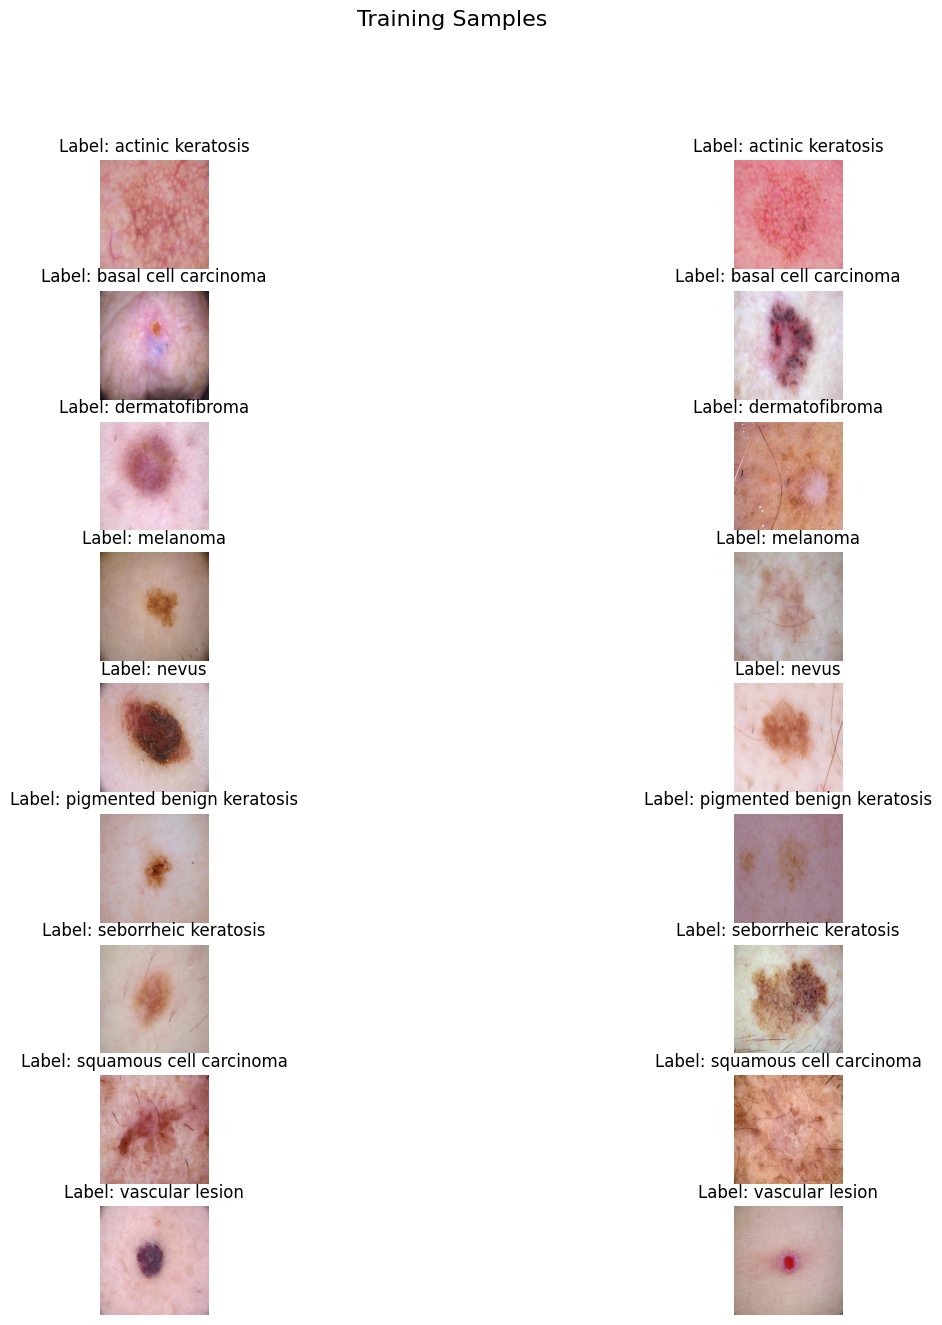

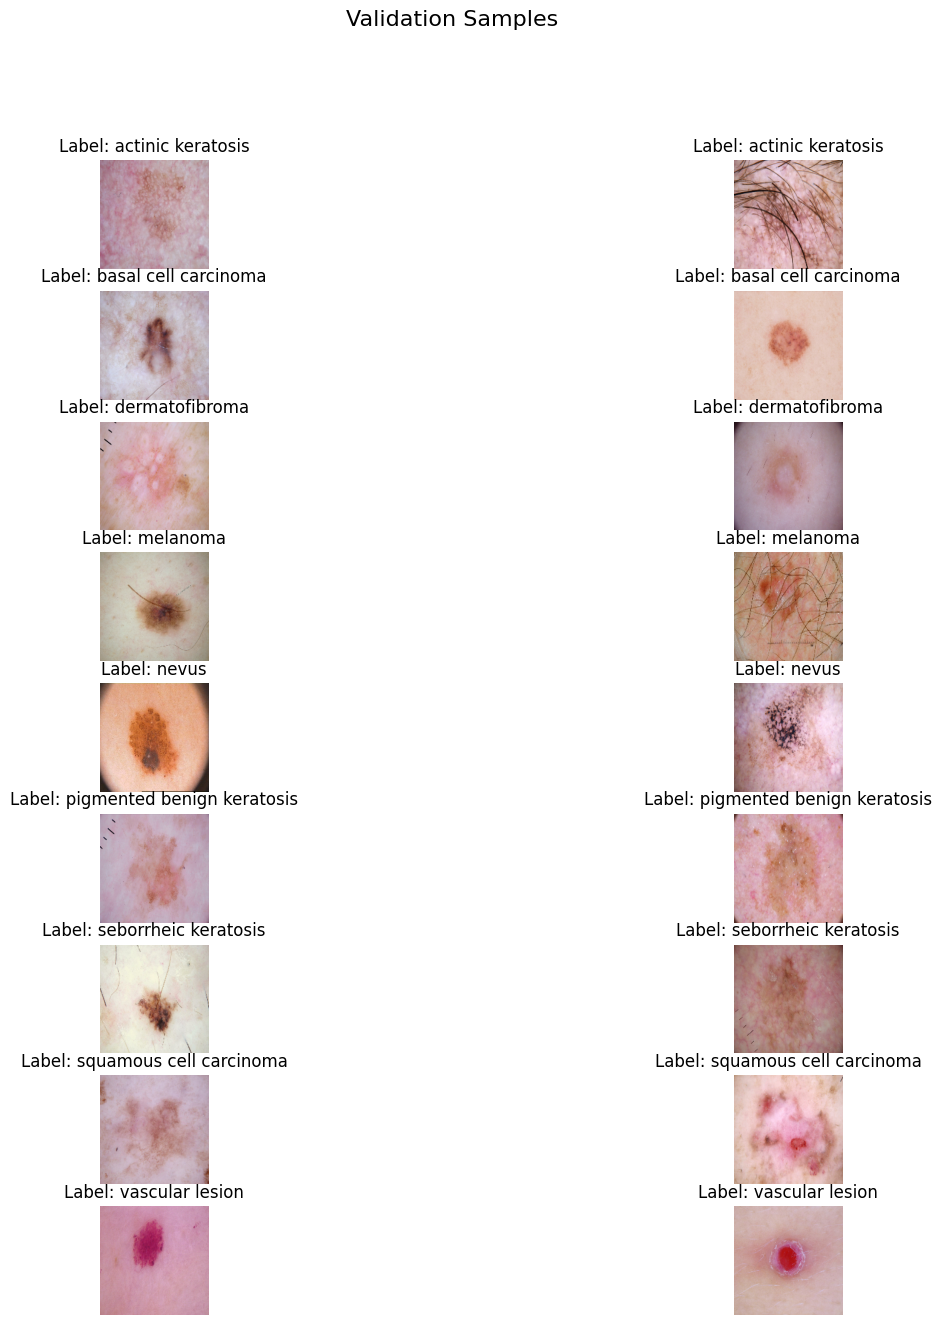

True

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
show_data(train_ds, 'Training Samples')
show_data(val_ds, 'Validation Samples')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here

scale_val = 1./255

model = Sequential()

#Scaling images from [0,255] to [0,1]
model.add( Rescaling(scale_val, input_shape=(img_height, img_width, 3)))


model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initializers.HeNormal(seed=123), bias_initializer=initializers.HeNormal(seed=123)))
model.add(Activation('relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initializers.HeNormal(seed=123), bias_initializer=initializers.HeNormal(seed=123)))
model.add(Activation('relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initializers.HeNormal(seed=123), bias_initializer=initializers.HeNormal(seed=123)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, kernel_initializer=initializers.HeNormal(seed=123), bias_initializer=initializers.HeNormal(seed=123)))
model.add(Activation('relu'))



model.add(Dense(9, kernel_initializer=initializers.HeNormal(seed=123), bias_initializer=initializers.HeNormal(seed=123)))
model.add(Activation('softmax'))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

None


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#train_ds.info()
print(type(train_ds))

print(type(val_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.2008 - loss: 4.8386 - val_accuracy: 0.1924 - val_loss: 2.0291
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.2113 - loss: 2.0078 - val_accuracy: 0.1879 - val_loss: 2.0233
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2583 - loss: 1.9779 - val_accuracy: 0.2506 - val_loss: 1.9191
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.2640 - loss: 1.9411 - val_accuracy: 0.3691 - val_loss: 1.8129
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3119 - loss: 1.8820 - val_accuracy: 0.3781 - val_loss: 1.7811
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3355 - loss: 1.8108 - val_accuracy: 0.4497 - val_loss: 1.6979
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3989 - loss: 1.7105 - val_accuracy: 0.3177 - val_loss: 1.8705
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3699 - loss: 1.7485 - val_accuracy: 0.4676 -

### Visualizing training results

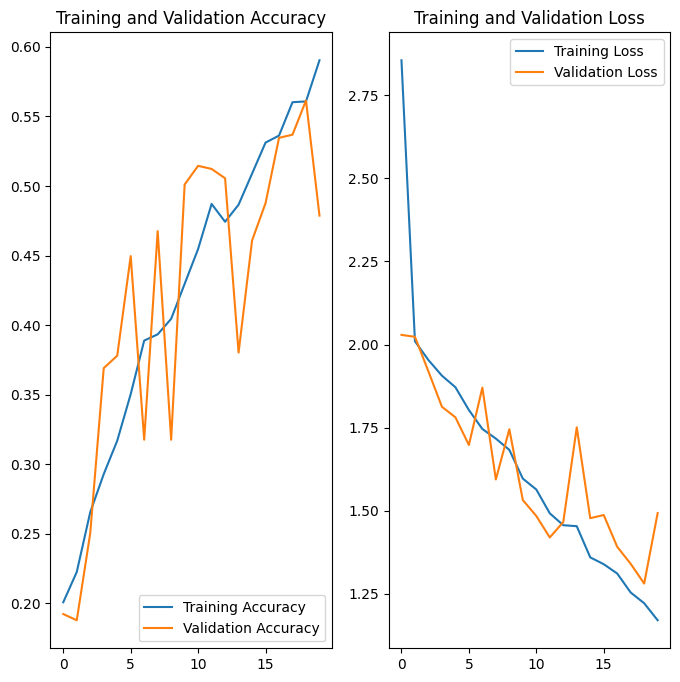

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
Findings

1.   Training accuracy and validation accuracy steadily increase. Similarly Training and valdiation loss dereases steadily over  epochs.
2.   Form the plots above the gap between the Training and validation loss curves indicates Model is overfitting
3.   Overfitting might be due to complexity of model and also due to lack of data augmentaion.

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
class_counts = {}
for label in class_names:
    class_counts[label] = len(os.listdir(os.path.join(data_dir_train, label)))

# Print the number of images for each label
for label, count in class_counts.items():
    print(f'Label: {label}, Count: {count}')


Label: actinic keratosis, Count: 114
Label: basal cell carcinoma, Count: 376
Label: dermatofibroma, Count: 95
Label: melanoma, Count: 438
Label: nevus, Count: 357
Label: pigmented benign keratosis, Count: 462
Label: seborrheic keratosis, Count: 77
Label: squamous cell carcinoma, Count: 181
Label: vascular lesion, Count: 139


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

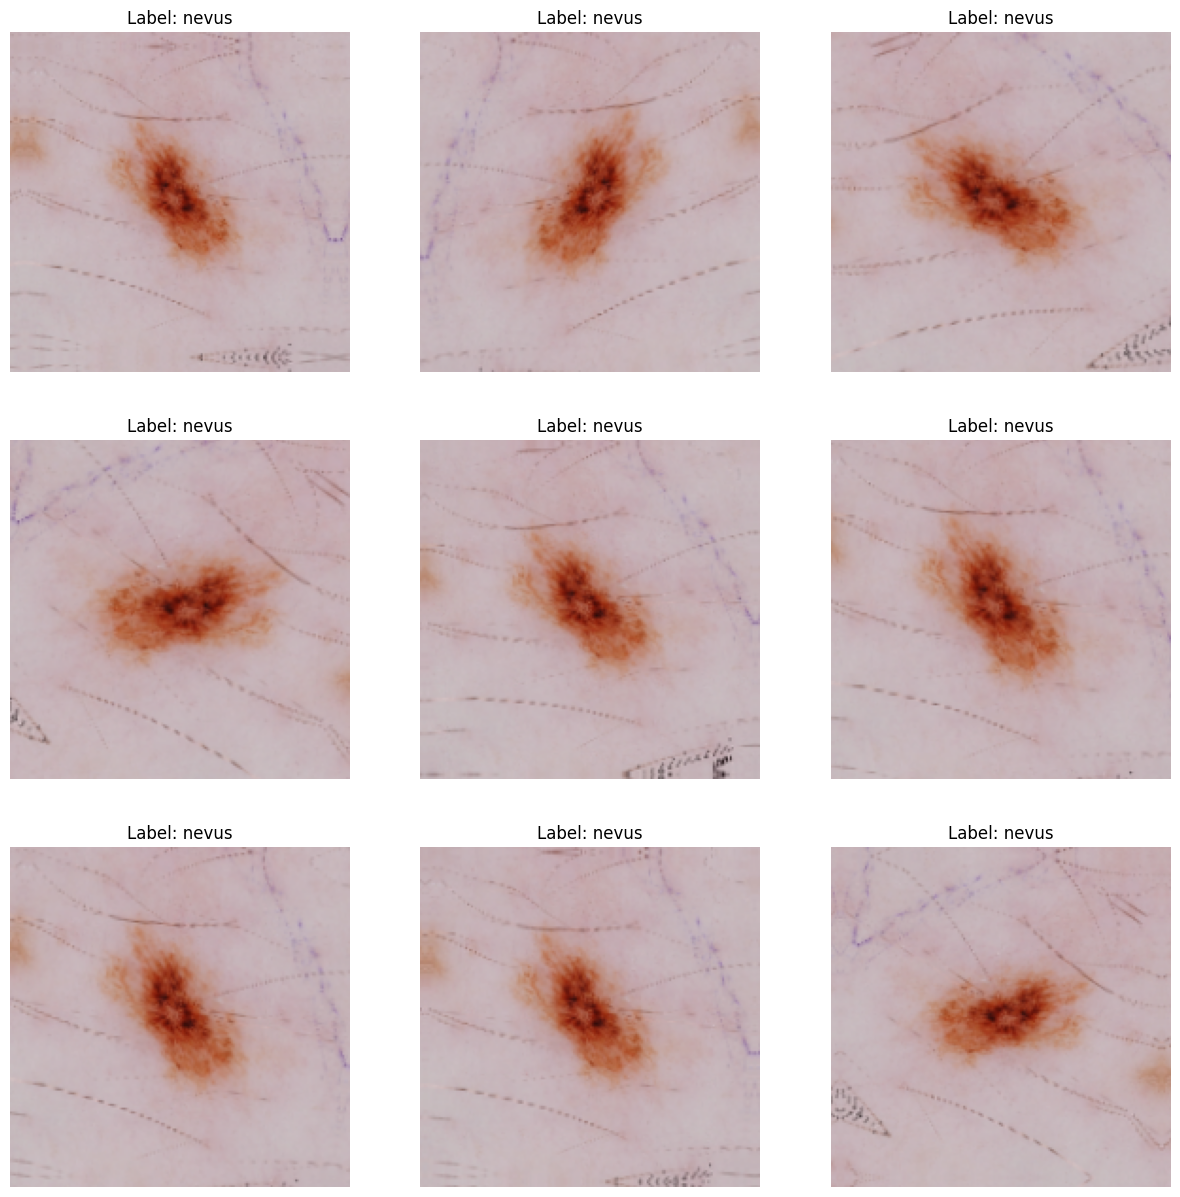

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.title(f"Label: {dLabels.get(labels[0].numpy())}")
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential()

#Scaling images from [0,255] to [0,1]
model.add( Rescaling(scale_val, input_shape=(img_height, img_width, 3)))

#model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initializers.HeNormal(seed=123), bias_initializer=initializers.HeNormal(seed=123)))
model.add(Activation('relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initializers.HeNormal(seed=123), bias_initializer=initializers.HeNormal(seed=123)))
model.add(Activation('relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initializers.HeNormal(seed=123), bias_initializer=initializers.HeNormal(seed=123)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))


model.add(Flatten())
#model.add(Dense(128))
model.add(Dense(128, kernel_initializer=initializers.HeNormal(seed=123), bias_initializer=initializers.HeNormal(seed=123)))
model.add(Activation('relu'))

model.add(Dropout(0.4))

#model.add(Dense(9))
model.add(Dense(9, kernel_initializer=initializers.HeNormal(seed=123), bias_initializer=initializers.HeNormal(seed=123)))
model.add(Activation('softmax'))



In [ ]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           1,161 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

In [ ]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.1782 - loss: 9.9777 - val_accuracy: 0.3154 - val_loss: 1.8769
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.2972 - loss: 1.9360 - val_accuracy: 0.3915 - val_loss: 1.6767
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.3874 - loss: 1.6902 - val_accuracy: 0.4609 - val_loss: 1.5772
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4651 - loss: 1.5419 - val_accuracy: 0.4944 - val_loss: 1.5159
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4638 - loss: 1.5064 - val_accuracy: 0.5145 - val_loss: 1.4502
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5225 - loss: 1.4123 - val_accuracy: 0.5056 - val_loss: 1.4191
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5027 - loss: 1.4159 - val_accuracy: 0.4944 - val_loss: 1.4143
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5205 - loss: 1.3330 - val_accuracy: 0.5391 - v

### Visualizing the results

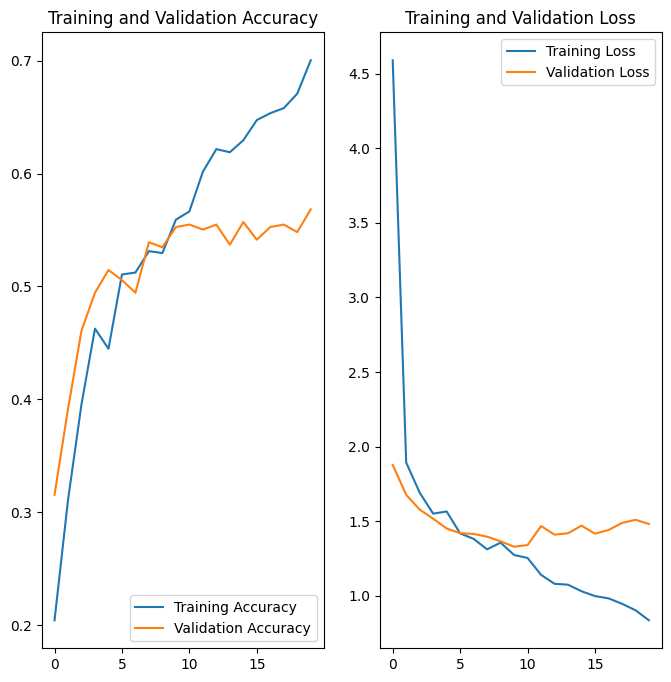

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:

import seaborn as sns
import pandas as pd
import numpy as np

def plot_class_count(ds,title):

      image_counts = {}
      for images, labels in val_ds:
          for label in labels.numpy():
              class_name = class_names[label]  # Get class name from label index
              image_counts[class_name] = image_counts.get(class_name, 0) + 1

      # Create DataFrame
      df = pd.DataFrame(list(image_counts.items()), columns=['Class', 'No. of Image'])

      # Plot
      plt.figure(figsize=(5, 5))
      sns.barplot(x='No. of Image', y='Class', data=df)
      plt.title(title)
      plt.show()


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?


*   Accuracy has increase increased ( from .60 to .6 ) and training loss reduced from .98 to .82
*   How ever its still over fitting as you can see gap between training and validation loss is high



#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

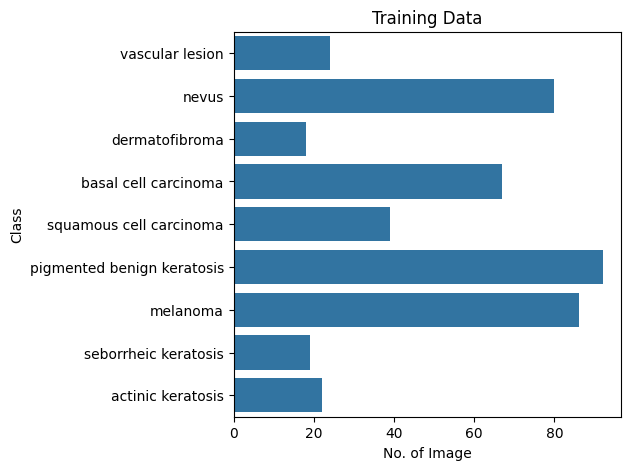

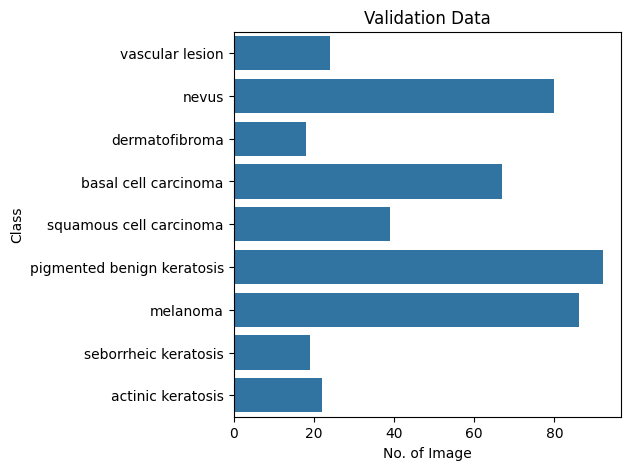

In [ ]:
## Your code goes here.
plot_class_count(train_ds,"Training Data")
plot_class_count(val_ds,"Validation Data")

# Extract data from val_ds
#image_counts = {}
#for images, labels in val_ds:
#    for label in labels.numpy():
#        class_name = class_names[label]  # Get class name from label index
#        image_counts[class_name] = image_counts.get(class_name, 0) + 1

# Create DataFrame
#df = pd.DataFrame(list(image_counts.items()), columns=['Class', 'No. of Image'])

# Plot
#plt.figure(figsize=(10, 8))
#sns.barplot(x='No. of Image', y='Class', data=df)
#plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?

'dermatofibroma' has lesat numebr of classes
#### - Which classes dominate the data in terms proportionate number of samples?
 'melanoma', 'nevus', 'pigmented benign keratosis' dominate in number of samples.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset=str(data_dir_train)+'/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FCFE4C4BA60>: 100%|██████████| 500/500 [00:19<00:00, 25.42 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCFE4A763E0>: 100%|██████████| 500/500 [00:18<00:00, 26.88 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCFE4A54220>: 100%|██████████| 500/500 [00:15<00:00, 32.21 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FCFD9FBB130>: 100%|██████████| 500/500 [01:26<00:00,  5.79 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD06C23F220>: 100%|██████████| 500/500 [01:12<00:00,  6.86 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD06C44B940>: 100%|██████████| 500/500 [00:15<00:00, 32.79 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD0503F0CD0>: 100%|██████████| 500/500 [00:36<00:00, 13.58 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD06C4453C0>: 100%|██████████| 500/500 [00:14<00:00, 35.51 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FCFE4A546D0>: 100%|██████████| 500/500 [00:15<00:00, 32.36 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
import glob # Import the glob module
import os


path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027142.jpg_e247cca8-994f-4825-9423-758a54c2c206.jpg',
 '/content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024581.jpg_ac83b2bf-40bb-49b5-9cee-3d23d8c97f59.jpg',
 '/content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026174.jpg_2e592164-86ec-4c08-aed3-9d04efbb413b.jpg',
 '/content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028343.jpg_44389b4d-75d8-4fe9-afe8-490fa50373ce.jpg',
 '/content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [ ]:
df2['Label'].value_counts()

,count
Label,
pigmented benign keratosis,500
vascular lesion,500
seborrheic keratosis,500
basal cell carcinoma,500
dermatofibroma,500
melanoma,500
nevus,500
squamous cell carcinoma,500
actinic keratosis,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here

## Your code goes here
model = Sequential()

#Scaling images from [0,255] to [0,1]
model.add( Rescaling(scale_val, input_shape=(img_height, img_width, 3)))

#model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initializers.HeNormal(seed=123), bias_initializer=initializers.HeNormal(seed=123)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))

#model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initializers.HeNormal(seed=123), bias_initializer=initializers.HeNormal(seed=123)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))

#model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initializers.HeNormal(seed=123), bias_initializer=initializers.HeNormal(seed=123)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))


model.add(Flatten())
#model.add(Dense(128))
model.add(Dense(128, kernel_initializer=initializers.HeNormal(seed=123), bias_initializer=initializers.HeNormal(seed=123)))
model.add(Activation('relu'))

model.add(Dropout(0.4))

#model.add(Dense(9))
model.add(Dense(9, kernel_initializer=initializers.HeNormal(seed=123), bias_initializer=initializers.HeNormal(seed=123)))
model.add(Activation('softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:


## Your code goes here
model.compile(optimizer='sgd', #adam
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 184ms/step - accuracy: 0.2312 - loss: 3.0969 - val_accuracy: 0.2606 - val_loss: 3.3607
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 26s 154ms/step - accuracy: 0.3938 - loss: 1.5930 - val_accuracy: 0.4209 - val_loss: 1.6445
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 159ms/step - accuracy: 0.4717 - loss: 1.3971 - val_accuracy: 0.5583 - val_loss: 1.2054
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 154ms/step - accuracy: 0.5359 - loss: 1.2530 - val_accuracy: 0.5835 - val_loss: 1.1125
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 26s 154ms/step - accuracy: 0.5886 - loss: 1.0841 - val_accuracy: 0.6615 - val_loss: 0.9342
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 178ms/step - accuracy: 0.6364 - loss: 0.9645 - val_accuracy: 0.7313 - val_loss: 0.7453
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 152ms/step - accuracy: 0.6691 - loss: 0.8664 - val_accuracy: 0.7001 - val_loss: 0.8493
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 25s 149ms/step - accuracy: 0.7133 - loss: 0

#### **Todo:**  Visualize the model results

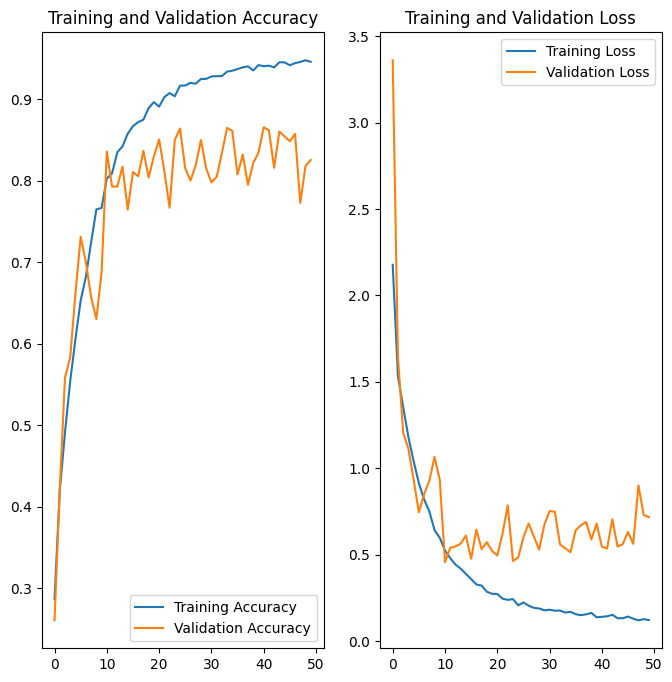

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

**Findings**

*   Overfitting had reduced after rebalancing and increasing the number of images for training
*   Accuracy for Traingin and validation has improved considerable after rebalancing and increasing the traning data
*   At 47 epoches results were better. We could add an early stop.




**Test Data Validation**

In [ ]:
model.evaluate(train_ds)

169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.9579 - loss: 0.0913


[0.07903628051280975, 0.9634643793106079]

In [ ]:
# Load the dataset with file paths and labels
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print(type(test_ds))

Found 118 files belonging to 9 classes.
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [ ]:
model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4250 - loss: 5.7552


[5.437928199768066, 0.43220338225364685]

In [ ]:
result = model.predict(test_ds)
dict(zip(model.metrics_names, result))

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 606ms/step


{'loss': array([2.6360727e-03, 9.8500639e-01, 6.2922641e-06, 8.6137698e-06,
        2.0860292e-03, 1.0087093e-02, 2.5629933e-07, 8.9934356e-06,
        1.6018921e-04], dtype=float32),
 'compile_metrics': array([0.14532344, 0.05989831, 0.02088082, 0.02934855, 0.02596054,
        0.7041917 , 0.00785852, 0.00176499, 0.00477321], dtype=float32)}

In [ ]:
predicted_categories = np.argmax (result, axis = 1)

In [ ]:
predicted_categories

array([1, 5, 7, 4, 4, 1, 8, 4, 4, 4, 5, 1, 7, 8, 4, 7, 3, 4, 4, 5, 7, 7,
       4, 4, 4, 0, 4, 5, 3, 4, 4, 3, 2, 0, 7, 0, 5, 4, 4, 7, 3, 4, 8, 7,
       1, 3, 0, 0, 0, 5, 4, 4, 3, 3, 5, 4, 8, 4, 3, 4, 4, 4, 4, 1, 2, 5,
       4, 1, 5, 4, 4, 4, 2, 8, 5, 1, 5, 4, 4, 8, 5, 1, 4, 5, 7, 5, 1, 3,
       7, 4, 5, 5, 1, 2, 4, 1, 7, 0, 4, 2, 3, 7, 5, 1, 5, 4, 3, 4, 0, 1,
       4, 5, 5, 1, 5, 7, 6, 4])

In [ ]:
true_categories = tf.concat([y for x, y in test_ds], axis=0)

In [ ]:
conf_mat=confusion_matrix(predicted_categories, true_categories)
conf_mat

array([[1, 0, 2, 2, 2, 0, 0, 0, 1],
       [1, 3, 1, 3, 3, 0, 1, 2, 0],
       [2, 1, 0, 1, 1, 0, 0, 0, 0],
       [0, 2, 0, 1, 0, 6, 0, 2, 0],
       [9, 3, 5, 2, 7, 4, 0, 8, 1],
       [2, 5, 4, 3, 3, 1, 1, 2, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 3, 3, 0, 4, 0, 2, 0],
       [0, 1, 1, 1, 0, 1, 1, 0, 1]])

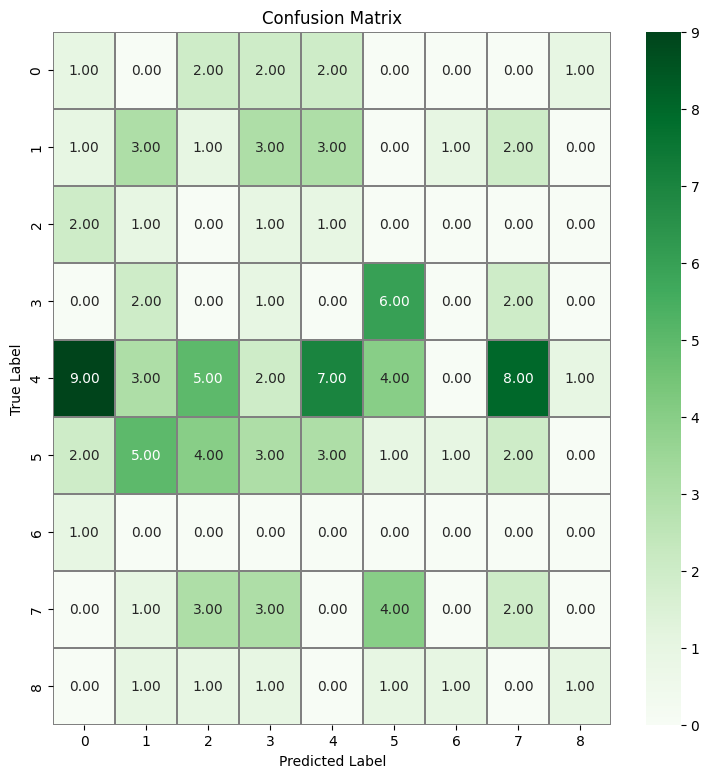

In [ ]:
f,ax = plt.subplots(figsize=(9, 9))
sns.heatmap(conf_mat, annot = True, linewidths = 0.01, cmap = "Greens", linecolor = "gray", fmt = ".2f", ax = ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()